<a href="https://colab.research.google.com/github/Rekt77/kisa_insuretech/blob/master/ted_analy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pandas.io.json import json_normalize
from wordcloud import WordCloud, STOPWORDS

In [0]:
# 나중에 사용할 리스트, 딕셔너리 날짜에 매핑

month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

In [49]:
path = "/content/drive/My Drive/insuretech/TED/ted_main.csv"

df = pd.read_csv(path)
df.columns

Index(['comments', 'description', 'duration', 'event', 'film_date',
       'languages', 'main_speaker', 'name', 'num_speaker', 'published_date',
       'ratings', 'related_talks', 'speaker_occupation', 'tags', 'title',
       'url', 'views'],
      dtype='object')

In [50]:
import datetime

#datetime의 포맷을 바꿔줌
#timestamp에서 일-월-년 형식
df['film_date'] = df['film_date'].apply(lambda x: datetime.datetime.fromtimestamp(int(x)).strftime('%d-%m-%Y'))
df['published_date'] = df['published_date'].apply(lambda x: datetime.datetime.fromtimestamp(int(x)).strftime('%d-%m-%Y'))
df.head()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,25-02-2006,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,27-06-2006,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110
1,265,With the same humor and humanity he exuded in ...,977,TED2006,25-02-2006,43,Al Gore,Al Gore: Averting the climate crisis,1,27-06-2006,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,24-02-2006,26,David Pogue,David Pogue: Simplicity sells,1,27-06-2006,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,26-02-2006,35,Majora Carter,Majora Carter: Greening the ghetto,1,27-06-2006,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550
4,593,You've never seen data presented like this. Wi...,1190,TED2006,22-02-2006,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,27-06-2006,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869


In [51]:
# 행의 개수
len(df)

2550

In [52]:
# 동영상의 Views를 기준으로 데이터를 정렬
pop_talks = df[['title', 'main_speaker', 'views', 'film_date']].sort_values('views', ascending=False).head(15)
pop_talks

,title,main_speaker,views,film_date
0,Do schools kill creativity?,Ken Robinson,47227110,25-02-2006
1346,Your body language may shape who you are,Amy Cuddy,43155405,26-06-2012
677,How great leaders inspire action,Simon Sinek,34309432,17-09-2009
837,The power of vulnerability,Brené Brown,31168150,06-06-2010
452,10 things you didn't know about orgasm,Mary Roach,22270883,06-02-2009
1776,How to speak so that people want to listen,Julian Treasure,21594632,10-06-2013
201,My stroke of insight,Jill Bolte Taylor,21190883,27-02-2008
5,Why we do what we do,Tony Robbins,20685401,02-02-2006
2114,This is what happens when you reply to spam email,James Veitch,20475972,08-12-2015
1416,"Looks aren't everything. Believe me, I'm a model.",Cameron Russell,19787465,27-10-2012


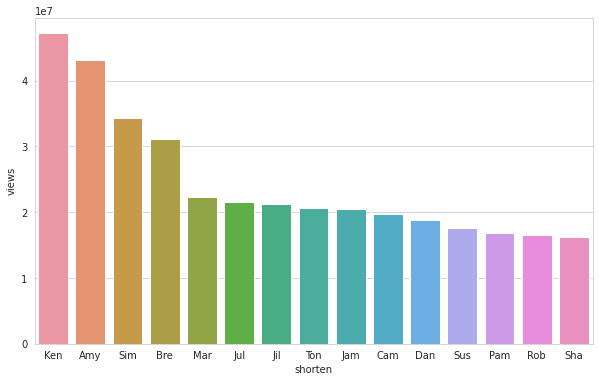

In [53]:
# 강연자별 조회수 막대그래프 출력
pop_talks['shorten'] = pop_talks['main_speaker'].apply(lambda x: x[:3]) # 스피커의 이름을 3글자로

# seaborn 시각화 라이브러리 사용
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))

# barplot으로 막대그래프
sns.barplot(x='shorten', y='views', data=pop_talks)

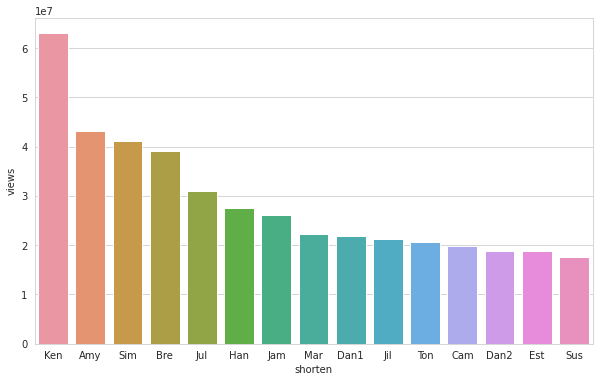

In [54]:
pop_talk = df[['main_speaker', 'views']].groupby("main_speaker", as_index=False).sum().sort_values("views", ascending=False).head(15)
pop_talk["shorten"] = pop_talk["main_speaker"].apply(lambda x: x[:3])

sns.set_style("whitegrid")
plt.figure(figsize=(10,6))

# Dan의 인덱스를 검색
pop_talk["shorten"].str.contains("Dan")

# Dan의 이름에서 중복을 제거
pop_talk.loc[433,"shorten"] = "Dan1"
pop_talk.loc[439,"shorten"] = "Dan2"

# barplot
sns.barplot(x='shorten', y='views', data=pop_talk)

count    2.550000e+03
mean     1.698297e+06
std      2.498479e+06
min      5.044300e+04
25%      7.557928e+05
50%      1.124524e+06
75%      1.700760e+06
max      4.722711e+07
Name: views, dtype: float64

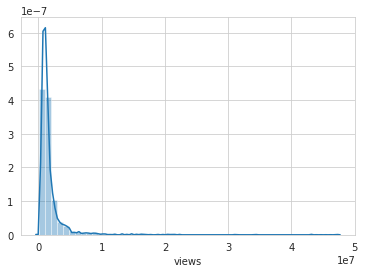

In [55]:
# views의 분포
# 4분위수 출력
sns.distplot(df['views'])
df['views'].describe()

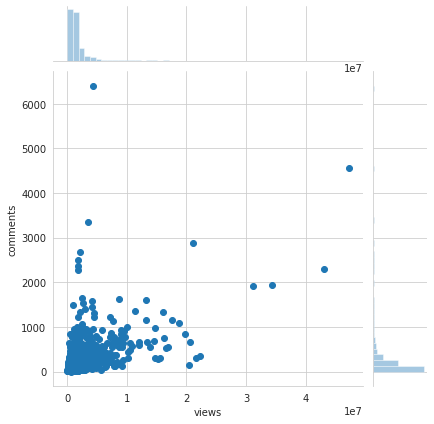

In [56]:
# 두 변수의 상관 관계를 보는 방법
sns.jointplot(x="views",y="comments", data=df)

In [57]:
# 두 변수간 상관계수 구하기
df[['views', 'comments']].corr()

,views,comments
views,1.000000,0.530939
comments,0.530939,1.000000


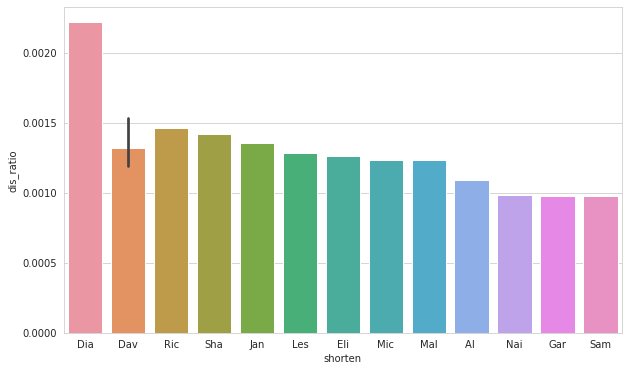

In [58]:
#조회수당 댓글작성 비율 구하기

#comment/view
pop_talk = df.loc[:,['title','main_speaker','views','comments','tags']]

# df에 새로운 컬럼 만들기
pop_talk["dis_ratio"] = pop_talk["comments"]/pop_talk["views"]
pop_talk["shorten"] = pop_talk["main_speaker"].apply(lambda x: x[:3])

# dis_ratio 내림차순으로 정렬하여 출력
pop_talk = pop_talk.sort_values('dis_ratio', ascending=False).head(15)

#### 과제1
# Dav의 이름을 바꿔서 중복을 제거해 주세요

sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
sns.barplot(x="shorten",y="dis_ratio",data=pop_talk)

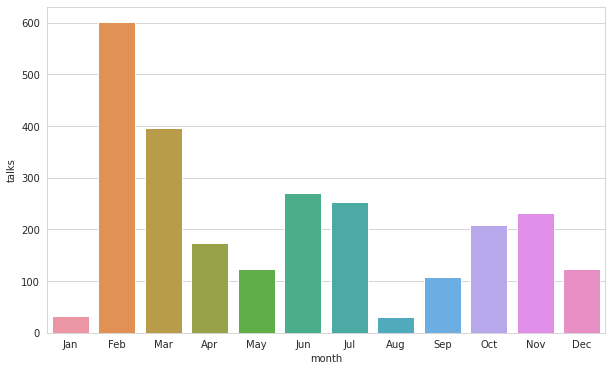

In [59]:
pub_view = df[['views','film_date']].sort_values('views', ascending=False)

# month order를 통해 숫자형 달(월)을 문자로 변환해서 month컬럼에 저장
pub_view["month"] = pub_view['film_date'].apply(lambda x: 
                                                     month_order[int(x.split("-")[1])-1])

# month의 데이터를 각각 세고 인덱스를 재설정
month_df = pd.DataFrame(pub_view['month'].value_counts()).reset_index()
month_df.columns = ['month', 'talks']

sns.set_style("whitegrid")
plt.figure(figsize=(10,6))

#month별 talks 비율
sns.barplot(x="month",y="talks",data=month_df,order=month_order)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


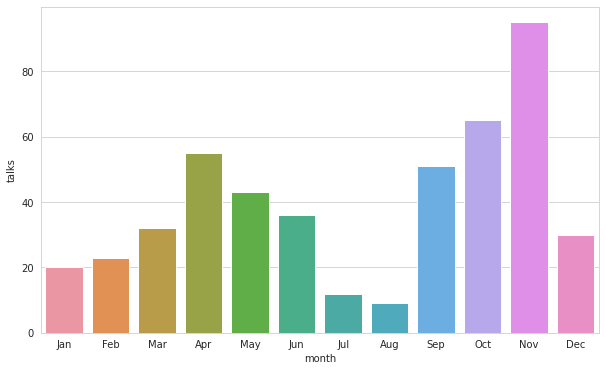

In [60]:
# event에 TEDx가 들어간 행만 마스킹
pub_event = df.loc[df['event'].str.contains("TEDx")]

# month order적용
pub_event["month"] = pub_event['film_date'].apply(lambda x: 
                                                     month_order[int(x.split("-")[1])-1])
# month의 데이터 세기
month_df = pd.DataFrame(pub_event['month'].value_counts()).reset_index()
month_df.columns = ['month', 'talks']

# 월별 TEDx에서 진행한 강연수
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
sns.barplot(x="month",y="talks",data=month_df,order=month_order)

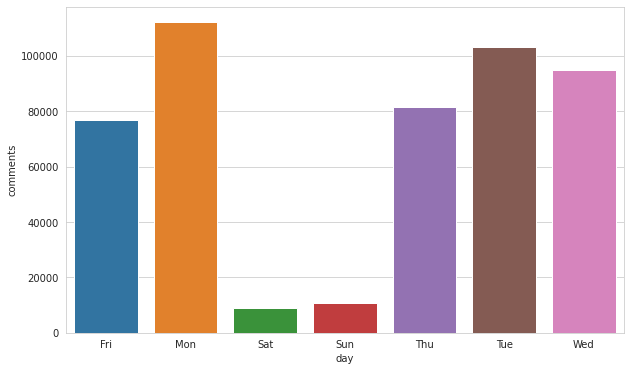

In [61]:
# weekday 월화수목금토일을 숫자로 바꾸어줌
# dayorder에 인덱스로 접근하기 위함
def getday(x):
    day, month, year = (int(i) for i in x.split('-'))    
    answer = datetime.date(year, month, day).weekday()
    return day_order[answer]

# comments,published_date 추출
day_com = df.loc[:,["comments","published_date"]]

# day 컬럼은 날짜에서 getday를 적용한 값(문자형 날짜)
day_com["day"] = day_com["published_date"].apply(getday)

# day의 그룹으로 묶어서 sum집계 코멘트가 집계됨
day_df = day_com.groupby("day").sum().reset_index()

# 무슨 요일에 발행된 강의가 댓글이 많이 달렸는가?
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
sns.barplot(x="day",y="comments",data=day_df)

# 히트맵 그래프

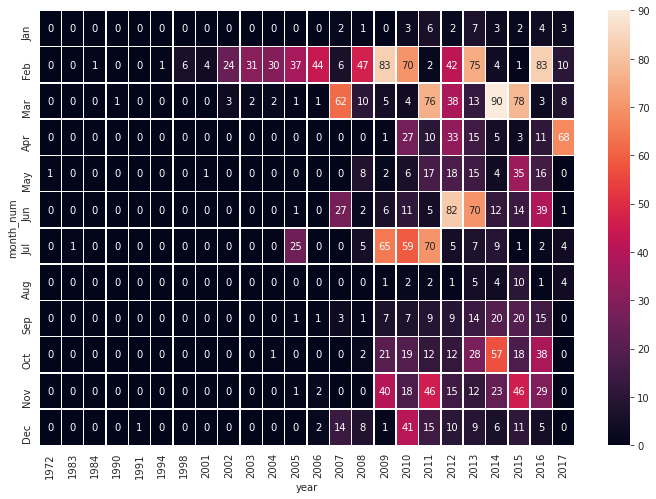

In [62]:
# 전체 데이터를 넣을 건데 hmap_df = df 로 선언시 레퍼런스 id를 공유하기 때문에 hmap_df가 원본데이터를 훼손할 수 있음
hmap_df = df.copy()

#film_date에 담기는 값 = Jan 2018 형식
hmap_df['film_date'] = hmap_df['film_date'].apply(lambda x: month_order[int(x.split('-')[1]) - 1] + " " + str(x.split('-')[2]))

#film_date각 요소의 출현회수를 종합
hmap_df = pd.DataFrame(hmap_df.loc[:,'film_date'].value_counts()).reset_index()
hmap_df.columns = ["film_date","counts"]

# months 딕셔너리에서 숫자를 매핑해주는 이유
# Jan, Apr 등은 스트링이기 때문에 정렬했을 경우에 1~12월 순이 아닐 수 있음
# ex> Apr(4월)이 가장 위에 나옴

#월을 나눔
hmap_df['month_num'] = hmap_df['film_date'].apply(lambda x: months[x.split()[0]])

#년을 나눔
hmap_df['year'] = hmap_df['film_date'].apply(lambda x: x.split()[1])
hmap_df = hmap_df.sort_values(['year', 'month_num'])

# 년-월 피봇테이블 작성 존재하지 않는 데이터는 0으로 처리
# pivot에 들어오는 인자 행,열,데이터
hmap_df = hmap_df[['month_num', 'year', 'counts']].pivot('month_num', 'year', 'counts')
hmap_df = hmap_df.fillna(0)

f, ax = plt.subplots(figsize=(12, 8))

# fmt -> 표시할 데이터의 포맷(float형이기 때문에 n을 입력)
# ax -> plot하고자 하는 figure
# annot -> 히트맵 상에 데이터 출력 여부
# month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sns.heatmap(hmap_df, annot=True, linewidths=.5, ax=ax, fmt='n', yticklabels=month_order)

In [63]:
hmap_df

year,1972,1983,1984,1990,1991,1994,1998,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
month_num,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,3.0,6.0,2.0,7.0,3.0,2.0,4.0,3.0
2,0.0,0.0,1.0,0.0,0.0,1.0,6.0,4.0,24.0,31.0,30.0,37.0,44.0,6.0,47.0,83.0,70.0,2.0,42.0,75.0,4.0,1.0,83.0,10.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,2.0,2.0,1.0,1.0,62.0,10.0,5.0,4.0,76.0,38.0,13.0,90.0,78.0,3.0,8.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,27.0,10.0,33.0,15.0,5.0,3.0,11.0,68.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,6.0,17.0,18.0,15.0,4.0,35.0,16.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,27.0,2.0,6.0,11.0,5.0,82.0,70.0,12.0,14.0,39.0,1.0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,5.0,65.0,59.0,70.0,5.0,7.0,9.0,1.0,2.0,4.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,5.0,4.0,10.0,1.0,4.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0,7.0,7.0,9.0,9.0,14.0,20.0,20.0,15.0,0.0


In [64]:
speaker_df = df.groupby('main_speaker').count()#.reset_index()[['main_speaker', 'comments']]
speaker_df

,comments,description,duration,event,film_date,languages,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
main_speaker,,,,,,,,,,,,,,,,
OK Go,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Rodrigo y Gabriela,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Silk Road Ensemble,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Sofi Tukker,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
AJ Jacobs,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ziauddin Yousafzai,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Ziyah Gafić,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Zubaida Bai,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


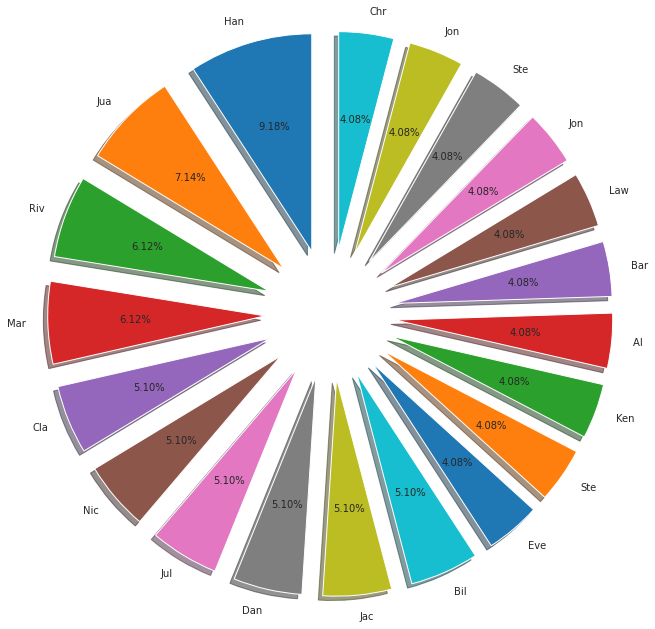

In [65]:
# 스피커의 출현빈도
# 스피커를 그룹으로 묶어서 각 컬럼의 값이 존재하기만 하면 출현시 마다 1씩 추가
# comments, desc, duration 등 아무거나 상관없음 모두 같은 값
speaker_df = df.groupby('main_speaker').count().reset_index()[['main_speaker', 'comments']]
speaker_df.columns = ['main_speaker', 'appearances']

#출현빈도 20위 까지 추출 후 abbr 만들기
speaker_df = speaker_df.sort_values('appearances', ascending=False)
speaker_appr = speaker_df.head(20)
speaker_appr["abbr"] = speaker_appr.loc[:,"main_speaker"].apply(lambda x:x[:3])
plt.figure(figsize=(10,10))
plt.pie(
    x="appearances",
    data=speaker_appr,
    labels=speaker_appr["abbr"],
    autopct='%1.2f%%', # second decimal place
    shadow=True,
    startangle=90,
    explode=[0.3 for _ in range(len(speaker_appr))]
)
plt.show()

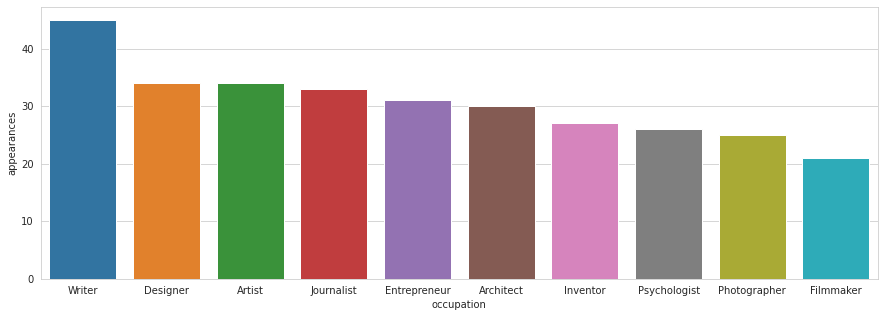

In [66]:
# 스피커의 직업 
occupation_df = pd.DataFrame(df.loc[:,'speaker_occupation'].value_counts()).reset_index()
occupation_df.columns = ['occupation', 'appearances']

#스피커의 직업별 출현빈도
occupation_df = occupation_df.sort_values('appearances', ascending=False)
plt.figure(figsize=(15,5))
sns.barplot(x='occupation', y='appearances', data=occupation_df.head(10))
plt.show()

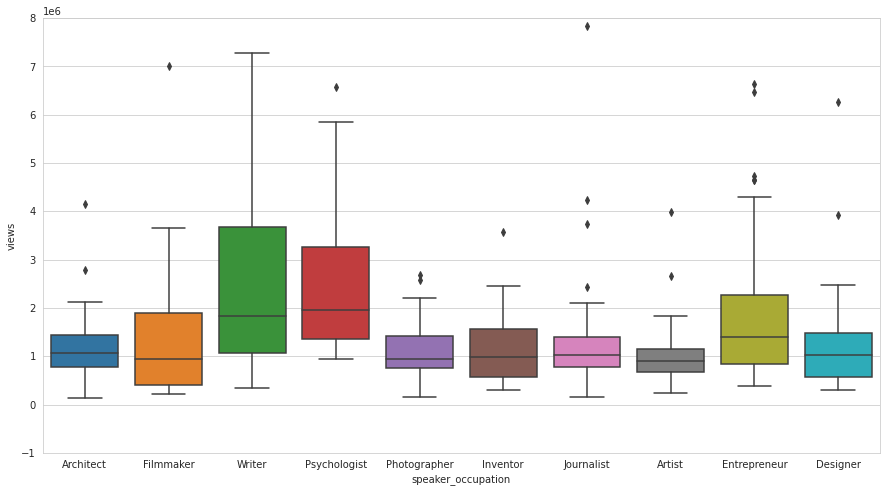

In [67]:
# 스피커의 직업별 조회수
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(x='speaker_occupation', y='views', data=df[df['speaker_occupation'].isin(occupation_df['occupation'].head(10))], ax =ax)
ax.set_ylim([-0.1e7, 0.8e7])
plt.show()

In [0]:
import ast

# 형변환 스트링 -> 리스트
df['tags'] = df['tags'].apply(lambda x: ast.literal_eval(x))

In [73]:
# 각 리스트를 받아서 인덱스별로 묶음
stacked = df.apply(lambda x: pd.Series(x['tags']),axis=1).stack()
print(stacked)
# 멀티인덱스에서 첫번째 인덱스를 두번째 인덱스로 옮기기 위함
stacked = stacked.reset_index(level=1,drop=True)
print(stacked)
stacked.name='theme'

0     0          children
      1        creativity
      2           culture
      3             dance
      4         education
                ...      
2549  4              play
      5     public spaces
      6           society
      7          software
      8    urban planning
Length: 19154, dtype: object
0             children
0           creativity
0              culture
0                dance
0            education
             ...      
2549              play
2549     public spaces
2549           society
2549          software
2549    urban planning
Length: 19154, dtype: object


In [75]:
# 태그 개수만큼 행이 늘어남
theme_df = df.drop('tags',axis='columns').join(stacked)
theme_df.head(10)

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,title,url,views,theme
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,25-02-2006,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,27-06-2006,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,children
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,25-02-2006,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,27-06-2006,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,creativity
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,25-02-2006,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,27-06-2006,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,culture
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,25-02-2006,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,27-06-2006,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,dance
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,25-02-2006,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,27-06-2006,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,education
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,25-02-2006,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,27-06-2006,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,parenting
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,25-02-2006,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,27-06-2006,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,teaching
1,265,With the same humor and humanity he exuded in ...,977,TED2006,25-02-2006,43,Al Gore,Al Gore: Averting the climate crisis,1,27-06-2006,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,alternative energy
1,265,With the same humor and humanity he exuded in ...,977,TED2006,25-02-2006,43,Al Gore,Al Gore: Averting the climate crisis,1,27-06-2006,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,cars
1,265,With the same humor and humanity he exuded in ...,977,TED2006,25-02-2006,43,Al Gore,Al Gore: Averting the climate crisis,1,27-06-2006,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,climate change


In [77]:
# 테마의 개수를 정리
pop_themes = pd.DataFrame(theme_df['theme'].value_counts()).reset_index()
pop_themes.columns = ['theme', 'talks']
pop_themes.head(10)

,theme,talks
0,technology,727
1,science,567
2,global issues,501
3,culture,486
4,TEDx,450
5,design,418
6,business,348
7,entertainment,299
8,health,236
9,innovation,229


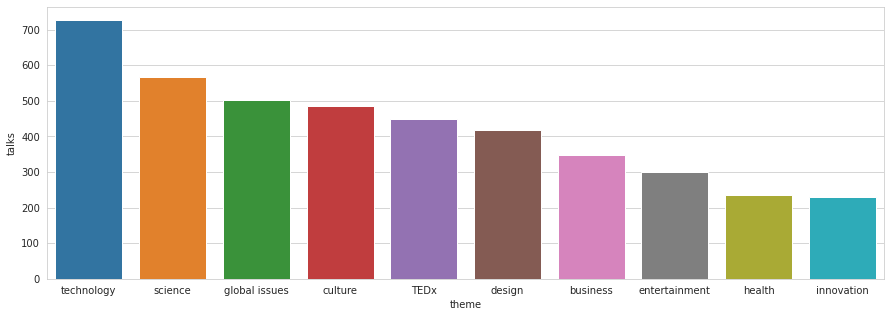

In [78]:
# 테마별 영상 개수 그래프
plt.figure(figsize=(15,5))
sns.barplot(x='theme', y='talks', data=pop_themes.head(10))
plt.show()

In [79]:
# 카테고리가 8위안에 들어있고 TEDx가 아닌경우
pop_theme_talks = theme_df[(theme_df['theme'].isin(pop_themes.head(8)['theme'])) & (theme_df['theme'] != 'TEDx')]
pop_theme_talks['year'] = pop_theme_talks['film_date'].apply(lambda x:x.split('-')[-1]).astype('int')

# 2009년 이후 데이터만
pop_theme_talks = pop_theme_talks[pop_theme_talks['year'] > 2008]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


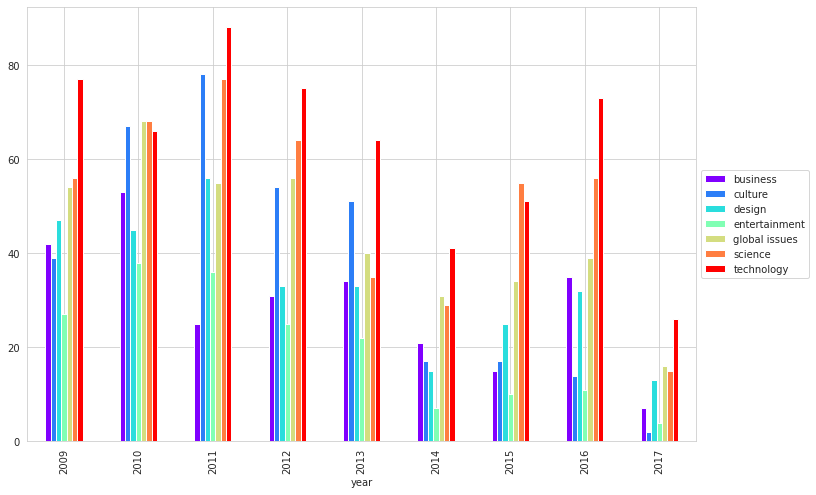

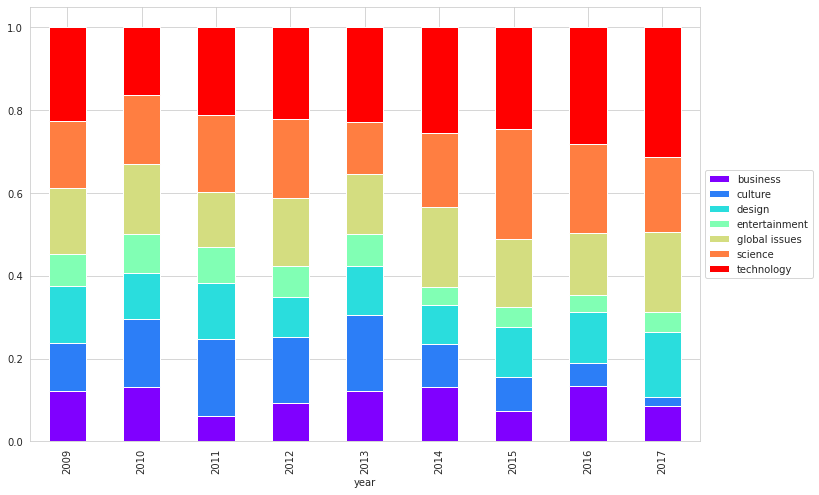

In [80]:
ctab_1 = pd.crosstab([pop_theme_talks['year']],
                     pop_theme_talks['theme'])

# 점유율 확인을 위해 전체를 나눔
ctab_2 = pd.crosstab([pop_theme_talks['year']],
                     pop_theme_talks['theme']).apply(lambda x: x/x.sum(), axis=1)

ctab_1.plot(kind='bar',
            stacked=False,
            colormap='rainbow',
            figsize=(12,8)).legend(loc='center left',
                                   bbox_to_anchor=(1, 0.5))
plt.show()

ctab_2.plot(kind='bar',
            stacked=True,
            colormap='rainbow',
            figsize=(12,8)).legend(loc='center left',
                                   bbox_to_anchor=(1, 0.5))
plt.show()

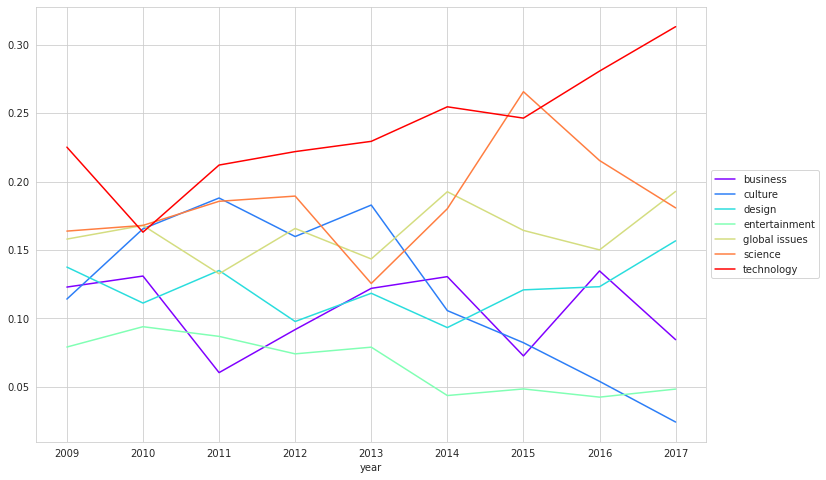

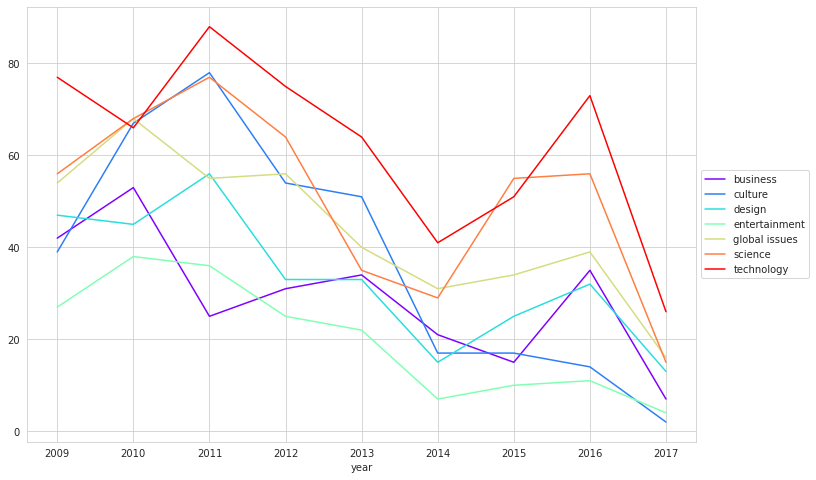

In [0]:
ctab_2.plot(kind='line',
            stacked=False,
            colormap='rainbow',
            figsize=(12,8)).legend(loc='center left',
                                   bbox_to_anchor=(1, 0.5))
plt.show()

ctab_1.plot(kind='line',
            stacked=False,
            colormap='rainbow',
            figsize=(12,8)).legend(loc='center left',
                                   bbox_to_anchor=(1, 0.5))
plt.show()

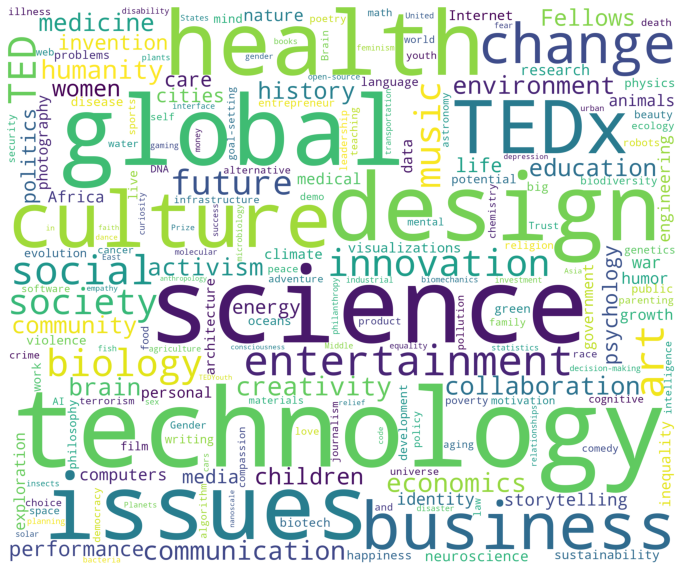

In [0]:
import collections
corpus = ' '.join(theme_df['theme']).split(' ')
corpus_dict = collections.Counter(corpus)
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2400,
                      height=2000).generate_from_frequencies(corpus_dict)
plt.figure(figsize=(12,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()